In [111]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Flatten, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
import numpy as np
import os
import pandas as pd
import pywt

In [65]:
epoch_num = 5
sequence_length = 8  # Number of time steps to consider

# Define file and directory names
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
# parent_dir = 'forexPredictor'
# repo = 'Repos_git'
# repo_dir = 'Make_Money_with_Tensorflow_2.0'
# Get the absolute base directory dynamically
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Move up one level

# Construct the full file path in an OS-independent way
# data_path = os.path.join(base_dir, repo, repo_dir, parent_dir, data_dir, file_name)
data_path = os.path.join(base_dir, data_dir, file_name)

# Check if the file exists before using it
if os.path.exists(data_path):
    print(f"✅ File found: {data_path}")
else:
    print(f"❌ Error: File not found at {data_path}")


ucols=['Open', 'High', 'Low', 'Close']
data_main = pd.read_csv(data_path, usecols=ucols)
data_main.reset_index(drop=True, inplace=True)
data_main.head()


✅ File found: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\0_61938.csv


,Open,High,Low,Close
0,1.20997,1.21089,1.20966,1.20999
1,1.20481,1.20569,1.20479,1.20538
2,1.20537,1.20574,1.20341,1.20553
3,1.20556,1.20689,1.20442,1.20469
4,1.20468,1.20599,1.20380,1.20573


In [129]:
df = data_main.iloc[:30000]
# Convert DataFrame to NumPy array
# data = df.values

<Axes: >

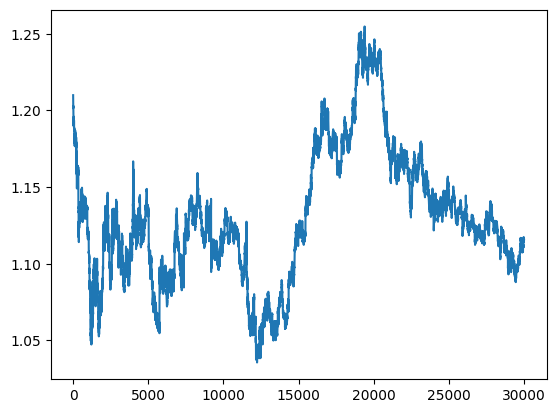

In [130]:
df['Close'].plot()

In [131]:
# Normalize Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

def apply_dwt(data):
    coeffs = [pywt.dwt(sample, 'haar') for sample in data]
    cA, cD = zip(*coeffs)
    return np.array(cA)  # Using only approximation coefficients

# Apply DWT
transformed_data = apply_dwt(df_scaled)
transformed_data = transformed_data.reshape((transformed_data.shape[0], transformed_data.shape[1], 1))

# Define LSTM Autoencoder
def create_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(input_layer)
    x = LSTM(32, return_sequences=False)(x)
    encoded = Dense(16, activation='relu')(x)
    
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(input_shape[0], activation='sigmoid')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder


In [ ]:
# Train Autoencoder
autoencoder, encoder = create_autoencoder(transformed_data.shape[1:])
autoencoder.fit(transformed_data, transformed_data, epochs=5, batch_size=32, verbose=1)

# Extract Features
features = encoder.predict(transformed_data)

# Clustering with TimeSeriesKMeans
num_clusters = 3  # Buy (2), Sell (1), Hold (0)
tskmeans = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", random_state=42)
clusters = tskmeans.fit_predict(features)
clusters_one_hot = tf.keras.utils.to_categorical(clusters, num_clusters)

# Split Data for Training
X_train, X_test, y_train, y_test = train_test_split(features, clusters_one_hot, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42, sampling_strategy='not majority')
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define Classifier
input_shape = features.shape[1:]  # Extract feature dimension
classifier_input = Input(shape=input_shape)
classifier_output = Dense(num_clusters, activation="softmax")(classifier_input)

classifier = Model(classifier_input, classifier_output)

Epoch 1/5
938/938 [==============================] - 5s 3ms/step - loss: 0.0116
Epoch 2/5
540/938 [================>.............] - ETA: 0s - loss: 0.0047

In [119]:
# Convert one-hot encoded labels to integer class labels
y_train_classes = np.argmax(y_train, axis=1)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_classes), y=y_train_classes)

# Convert to dictionary
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train Classifier with Class Weights
classifier.fit(X_train, y_train, 
               validation_data=(X_test, y_test), 
               epochs=5, 
               batch_size=32, 
               class_weight=class_weight_dict)

# Save the model
classifier.save('model.h5')

# Evaluate Model
loss, accuracy = classifier.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/5
418/418 [==============================] - 1s 1ms/step - loss: 0.7855 - accuracy: 0.6096 - val_loss: 0.5418 - val_accuracy: 0.9750
Epoch 2/5
418/418 [==============================] - 0s 1000us/step - loss: 0.4706 - accuracy: 0.9592 - val_loss: 0.3811 - val_accuracy: 0.9710
Epoch 3/5
418/418 [==============================] - 0s 948us/step - loss: 0.3498 - accuracy: 0.9848 - val_loss: 0.2949 - val_accuracy: 0.9820
Epoch 4/5
418/418 [==============================] - 0s 923us/step - loss: 0.2770 - accuracy: 0.9891 - val_loss: 0.2380 - val_accuracy: 0.9870
Epoch 5/5
63/63 [==============================] - 0s 769us/step - loss: 0.1953 - accuracy: 0.9935
Test Accuracy: 99.35%


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 0s 488us/step
Confusion Matrix:
[[ 651    0    0]
 [  13 1102    0]
 [   0    0  234]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       651
           1       1.00      0.99      0.99      1115
           2       1.00      1.00      1.00       234

    accuracy                           0.99      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       0.99      0.99      0.99      2000



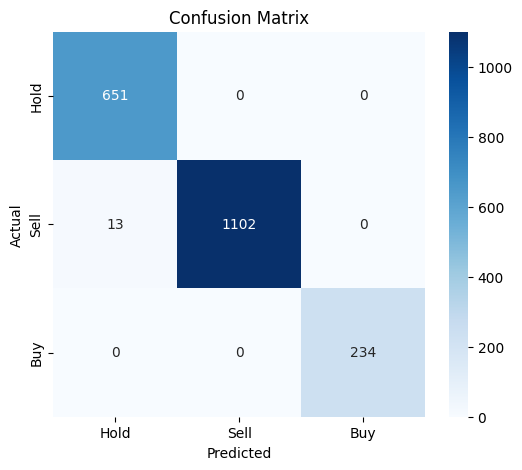

In [120]:
# Confusion Matrix & Classification Report
y_pred = classifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_classes, y_pred_classes), annot=True, fmt='d', cmap='Blues', xticklabels=['Hold', 'Sell', 'Buy'], yticklabels=['Hold', 'Sell', 'Buy'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

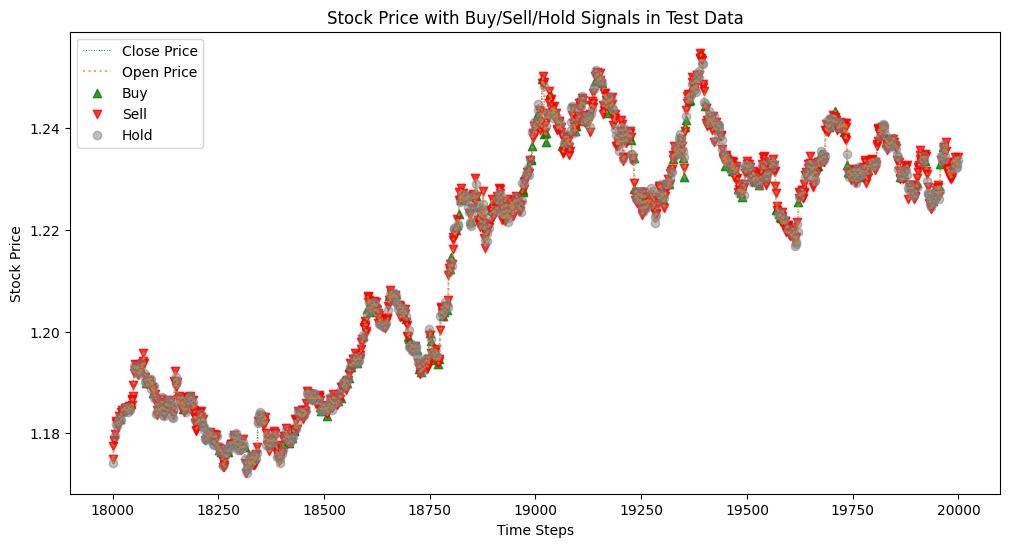

In [121]:
# Ensure indices align correctly
df_test = df.iloc[-len(X_test):].copy()  # Copy test data portion

# Convert y_pred_classes to Pandas Series with the correct index
y_pred_series = pd.Series(y_pred_classes, index=df_test.index)

# Plot OHLC Data
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test["Close"], label='Close Price', linestyle='dotted', linewidth=0.7)
plt.plot(df_test.index, df_test["Open"], label='Open Price', linestyle='dotted', alpha=0.7)
# plt.plot(df_test.index, df_test["High"], label='High Price', linestyle='dotted', alpha=0.7)
# plt.plot(df_test.index, df_test["Low"], label='Low Price', linestyle='dotted', alpha=0.7)

# Find Buy, Sell, Hold signals
buy_signals = df_test.index[y_pred_series == 2]
sell_signals = df_test.index[y_pred_series == 1]
hold_signals = df_test.index[y_pred_series == 0]

# Plot Signals on Close Price
plt.scatter(buy_signals, df_test.loc[buy_signals, "Close"], marker='^', color='green', label='Buy', alpha=0.8)
plt.scatter(sell_signals, df_test.loc[sell_signals, "Close"], marker='v', color='red', label='Sell', alpha=0.8)
plt.scatter(hold_signals, df_test.loc[hold_signals, "Close"], marker='o', color='gray', label='Hold', alpha=0.5)

plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price with Buy/Sell/Hold Signals in Test Data")
plt.show()


In [125]:
# documentation: https://www.mql5.com/en/docs/integration/python_metatrader5

import MetaTrader5 as mt  # pip install MetaTrader5
import pandas as pd  # pip install pandas
from datetime import datetime, timedelta
import os

# start the platform with initialize()
mt.initialize()

# login to Trade Account with login()
# make sure that trade server is enabled in MT5 client terminal

login = 165905041
password = 'iIeElL0176_'
server = 'XMGlobal-MT5 2'

mt.login(login, password, server)



# Define symbol and timeframe
symbol = "EURUSD"
timeframe = mt.TIMEFRAME_H1

# Get data for the last 48 hours
end_time = datetime.now()
start_time = end_time - timedelta(hours=1000)

# Retrieve OHLC data
ohlc_data = pd.DataFrame(mt.copy_rates_range(symbol, timeframe, start_time, end_time))

# Convert time column to datetime format
ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')


ohlc_data.rename(columns={'open':'Open', 'high':'High', 
                        'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
columns_to_drop = ['time', 'spread', 'real_volume', 'Volume']
ohlc_data.drop(columns=[col for col in columns_to_drop if col in ohlc_data.columns], inplace=True)



In [126]:
ohlc_data

,Open,High,Low,Close
0,1.04245,1.04309,1.03719,1.04083
1,1.04082,1.04419,1.04074,1.04362
2,1.04362,1.04651,1.04346,1.04607
3,1.04610,1.04665,1.04562,1.04627
4,1.04622,1.04676,1.04576,1.04654
...,...,...,...,...
708,1.07794,1.07805,1.07628,1.07682
709,1.07681,1.07816,1.07672,1.07721
710,1.07720,1.07735,1.07532,1.07640
711,1.07642,1.07759,1.07547,1.07751


23/23 [==============================] - 0s 402us/step


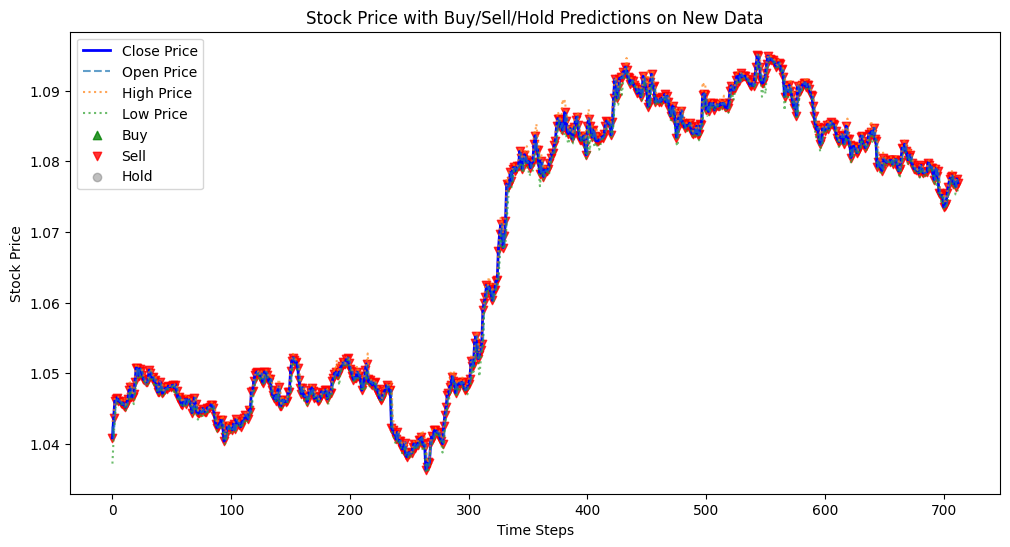

      Open     High      Low    Close Prediction
0  1.04245  1.04309  1.03719  1.04083       Sell
1  1.04082  1.04419  1.04074  1.04362       Sell
2  1.04362  1.04651  1.04346  1.04607       Sell
3  1.04610  1.04665  1.04562  1.04627       Sell
4  1.04622  1.04676  1.04576  1.04654       Sell
5  1.04653  1.04663  1.04551  1.04606       Sell
6  1.04607  1.04661  1.04569  1.04599       Sell
7  1.04600  1.04660  1.04573  1.04583       Sell
8  1.04582  1.04602  1.04544  1.04557       Sell
9  1.04557  1.04608  1.04528  1.04579       Sell


In [127]:
new_df = ohlc_data

# Normalize Data using the same scaler
new_df_scaled = scaler.transform(new_df)  # Use the previously fitted scaler

# Apply DWT Transformation
new_transformed_data = apply_dwt(new_df_scaled)
new_transformed_data = new_transformed_data.reshape((new_transformed_data.shape[0], new_transformed_data.shape[1], 1))

# Extract Features using the Encoder
new_features = encoder.predict(new_transformed_data)

# Predict Buy/Sell/Hold Signals
new_predictions = classifier.predict(new_features)
new_pred_classes = np.argmax(new_predictions, axis=1)  # Convert probabilities to class labels

# Convert predictions to a Pandas Series with matching index
new_pred_series = pd.Series(new_pred_classes, index=new_df.index)

# Plot OHLC with Predictions
plt.figure(figsize=(12, 6))
plt.plot(new_df.index, new_df["Close"], label='Close Price', color='blue', linewidth=2)
plt.plot(new_df.index, new_df["Open"], label='Open Price', linestyle='dashed', alpha=0.7)
plt.plot(new_df.index, new_df["High"], label='High Price', linestyle='dotted', alpha=0.7)
plt.plot(new_df.index, new_df["Low"], label='Low Price', linestyle='dotted', alpha=0.7)

# Find Buy, Sell, Hold signals
buy_signals = new_df.index[new_pred_series == 2]
sell_signals = new_df.index[new_pred_series == 1]
hold_signals = new_df.index[new_pred_series == 0]

# Plot Signals on Close Price
plt.scatter(buy_signals, new_df.loc[buy_signals, "Close"], marker='^', color='green', label='Buy', alpha=0.8)
plt.scatter(sell_signals, new_df.loc[sell_signals, "Close"], marker='v', color='red', label='Sell', alpha=0.8)
plt.scatter(hold_signals, new_df.loc[hold_signals, "Close"], marker='o', color='gray', label='Hold', alpha=0.5)

plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price with Buy/Sell/Hold Predictions on New Data")
plt.show()

# Save Predictions
new_df["Prediction"] = new_pred_series.map({0: "Hold", 1: "Sell", 2: "Buy"})
new_df.to_csv("predicted_results_new.csv", index=False)

# Print first 10 rows of results
print(new_df.head(10))


In [108]:
new_df.Prediction.values


array(['Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy',

In [123]:
unique, counts = np.unique(y_test_classes, return_counts=True)
print("Class Distribution in Test Data:", dict(zip(unique, counts)))

Class Distribution in Test Data: {0: 651, 1: 1115, 2: 234}
